In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR
from datasets import inputs
import seaborn as sns
import pandas as pd

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [126]:
dataset = inputs.Sim1DFeederAndCache(
    steps_in_phases=[0,2000,0],
    left_right_stay_prob=[3,1,1], expansion=1,
    num_spatial_states=16,
    visit_length=5,
    feeder_states=[], cache_states=list(range(7, 16)),
    cache_prob = 0.017
    )

# Sanity Check Plots

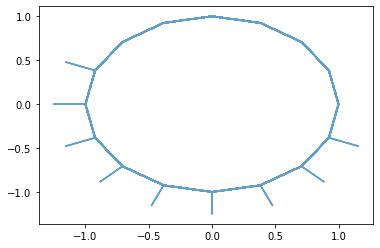

In [127]:
plt.figure();
plt.plot(dataset.xs, dataset.ys, alpha=0.7)
plt.show()

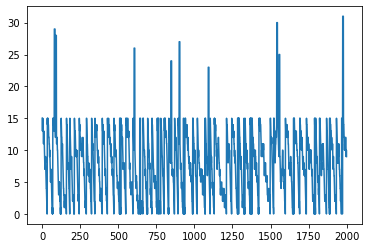

In [128]:
plt.figure();
plt.plot(dataset.state_inputs)
plt.show()

# Run through model

In [129]:
def get_M(T, gamma):
    return np.linalg.pinv(np.eye(T.shape[0]) - gamma*T)
    
def normalize(T):
    row_sums = np.sum(T, axis=1)
    unvisited_states = (row_sums == 0)
    T = T/row_sums[:, np.newaxis]
    T[unvisited_states] = 0
    return T

In [130]:
outputs = []
T_counts = np.zeros((dataset.num_expanded_states, dataset.num_expanded_states))
for step in np.arange(1, dataset.num_steps):
    prev_state = dataset.expanded_state_inputs[step-1]
    curr_state = dataset.expanded_state_inputs[step]
    T_counts[prev_state, curr_state] +=1

# Plot by dist

In [131]:
from scipy.stats import pearsonr

In [132]:
gamma = 0.9

In [133]:
M = get_M(normalize(T_counts), gamma)

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_47847/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


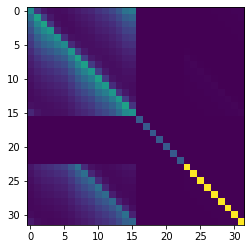

In [134]:
plt.figure()
plt.imshow(M)
plt.show()

In [135]:
cache_locs = np.array(dataset.cache_states)
cache_states = np.array(dataset.cache_states) + dataset.num_spatial_states

In [142]:
def get_similarities(indices, noise_loc, noise_scale):
    similarities = []
    for dist in range(len(dataset.cache_states)):
        arr1 = M[indices[0]].copy()
        arr2 = M[indices[dist]].copy()
        arr1 += np.random.normal(noise_loc, noise_scale, size=arr1.size)
        arr2 += np.random.normal(noise_loc, noise_scale, size=arr1.size)
        arr1[arr1 < 0] = 0
        arr2[arr2 < 0] = 0
        cc = pearsonr(arr1, arr2)[0]
        similarities.append(cc)
    return similarities


std = 0.7
iters = 60
similarities = []
dists = []
events = []
for _ in range(iters):
    sim = get_similarities(cache_locs, 0, std)
    similarities.extend(sim)
    dists.extend(list(range(len(sim))))
    events.extend(['Spatial']*len(sim))
    similarities.extend(sim[1:])
    dists.extend(list(range(-1, -len(sim), -1)))
    events.extend(['Spatial'] * (len(sim)-1))
    
for _ in range(iters):
    sim = get_similarities(cache_states, 0, std)
    similarities.extend(sim)
    dists.extend(list(range(len(sim))))
    events.extend(['Cache']*len(sim))
    similarities.extend(sim[1:])
    dists.extend(list(range(-1, -len(sim), -1)))
    events.extend(['Cache'] * (len(sim)-1))

In [143]:
df = pd.DataFrame({
    'Similarity': similarities, 'Distance': dists,
    'Event': events
    })

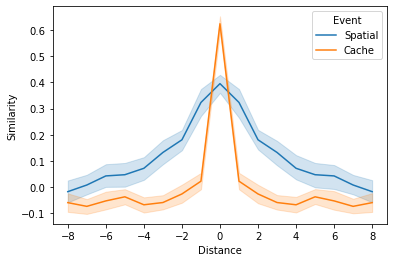

In [144]:
plt.figure()
sns.lineplot(x='Distance', y='Similarity', hue='Event', data=df)
plt.savefig('Similarity.png', dpi=300)
plt.show()